In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.metrics import classification_report

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

# Keras
from keras import models, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications import VGG16

# Warnings
import warnings
warnings.filterwarnings("ignore")

E:\Anaconda\envs\chexscan\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Check GPU

In [2]:
# Check for available physical GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # If there are GPUs available, TensorFlow should automatically utilize them
    print("Available GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU(s) available.")

No GPU(s) available.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU(s),", len(logical_gpus), "Logical GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


### Jerick PC

# Access image directory
root_dir = r"E:/JEAN/chexscan/data"
train_dir = root_dir + "/train_data"
valid_dir = root_dir + "/test_data"

### Emman Laptop

In [5]:
# Access image directory
root_dir = r"E:\Jean Eileen Magtibay\chexscan\dataset"
train_dir = root_dir + "/train"
valid_dir = root_dir + "/valid"

### Declaration

In [6]:
# Acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

['Normal', 'Pneumonia', 'Tuberculosis']


In [7]:
IMAGE_SIZE = 224
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 25

n_classes = len(class_names)
n_classes

3

## Data Generator

In [8]:
img_size = (IMAGE_SIZE, IMAGE_SIZE)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    rotation_range=20,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1680 images belonging to 3 classes.


In [9]:
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical'
)

Found 420 images belonging to 3 classes.


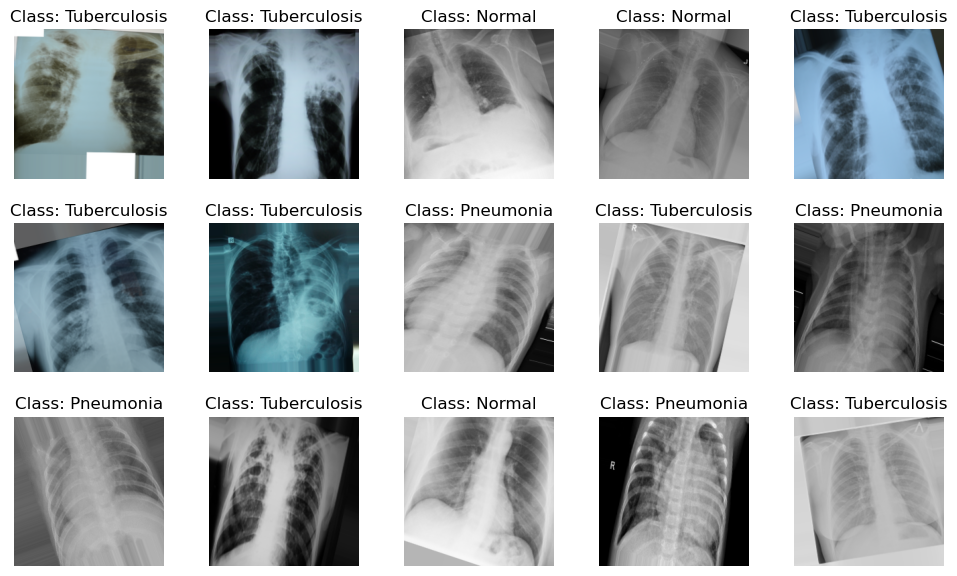

In [10]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])

    # Convert the float target to integer (0 or 1)
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]

    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [11]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
# class MyCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_acc') > 0.99:
#             print("\nReached accuracy threshold! Terminating training.")
#             # self.model.stop_training = False

# my_callback = MyCallback()

#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold_count):
        super(MyCallback, self).__init__()
        self.threshold_count = threshold_count
        self.consecutive_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            self.consecutive_count += 1
            if self.consecutive_count >= self.threshold_count:
                print("\nReached accuracy threshold 3 times! Terminating training.")
                self.model.stop_training = True
        else:
            self.consecutive_count = 0

# Define the callback with the threshold count
my_callback = MyCallback(threshold_count=3)

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss",
                                 patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

# VGG16

In [12]:
input_layer=layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

model_vgg16 = VGG16(weights='imagenet',
                    input_tensor=input_layer,
                    include_top=False)

last_layer=model_vgg16.output

flatten=layers.Flatten()(last_layer)

output_layer=layers.Dense(n_classes,activation='softmax')(flatten)

model_vgg16=models.Model(inputs=input_layer,outputs=output_layer)

# Making all the layers intrainable except the last layer
for layer in model_vgg16.layers[:-1]:
    layer.trainable=False

In [13]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

CALLBACKS = [my_callback, rop_callback, earlystop_cb] # Removed due to stopping condition 
# CALLBACKS = [rop_callback]


In [14]:
model_vgg16.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
# model_vgg16.summary()

In [15]:
history_vgg = model_vgg16.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    verbose=True,
    validation_data=valid_generator,
    callbacks=CALLBACKS,
    epochs=EPOCHS
)

Epoch 1/25
53/53 [==============================] - 151s 3s/step - loss: 0.5021 - acc: 0.8821 - f1_score: 0.8220 - val_loss: 0.1459 - val_acc: 0.9635 - val_f1_score: 0.9455
Epoch 2/25
53/53 [==============================] - 154s 3s/step - loss: 0.1303 - acc: 0.9728 - f1_score: 0.9582 - val_loss: 0.0916 - val_acc: 0.9754 - val_f1_score: 0.9644
Epoch 3/25
53/53 [==============================] - 159s 3s/step - loss: 0.1120 - acc: 0.9748 - f1_score: 0.9619 - val_loss: 0.0895 - val_acc: 0.9810 - val_f1_score: 0.9715
Epoch 4/25
53/53 [==============================] - 155s 3s/step - loss: 0.0966 - acc: 0.9794 - f1_score: 0.9696 - val_loss: 0.0792 - val_acc: 0.9810 - val_f1_score: 0.9715
Epoch 5/25
53/53 [==============================] - 154s 3s/step - loss: 0.0754 - acc: 0.9845 - f1_score: 0.9756 - val_loss: 0.0737 - val_acc: 0.9857 - val_f1_score: 0.9786
Epoch 6/25
53/53 [==============================] - 153s 3s/step - loss: 0.0759 - acc: 0.9833 - f1_score: 0.9756 - val_loss: 0.0701 - v

In [16]:
predictions = model_vgg16.predict(valid_generator)

# Obtain the true labels from the test_generator
true_labels = valid_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       140
   Pneumonia       1.00      0.99      0.99       140
Tuberculosis       0.97      0.99      0.98       140

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420



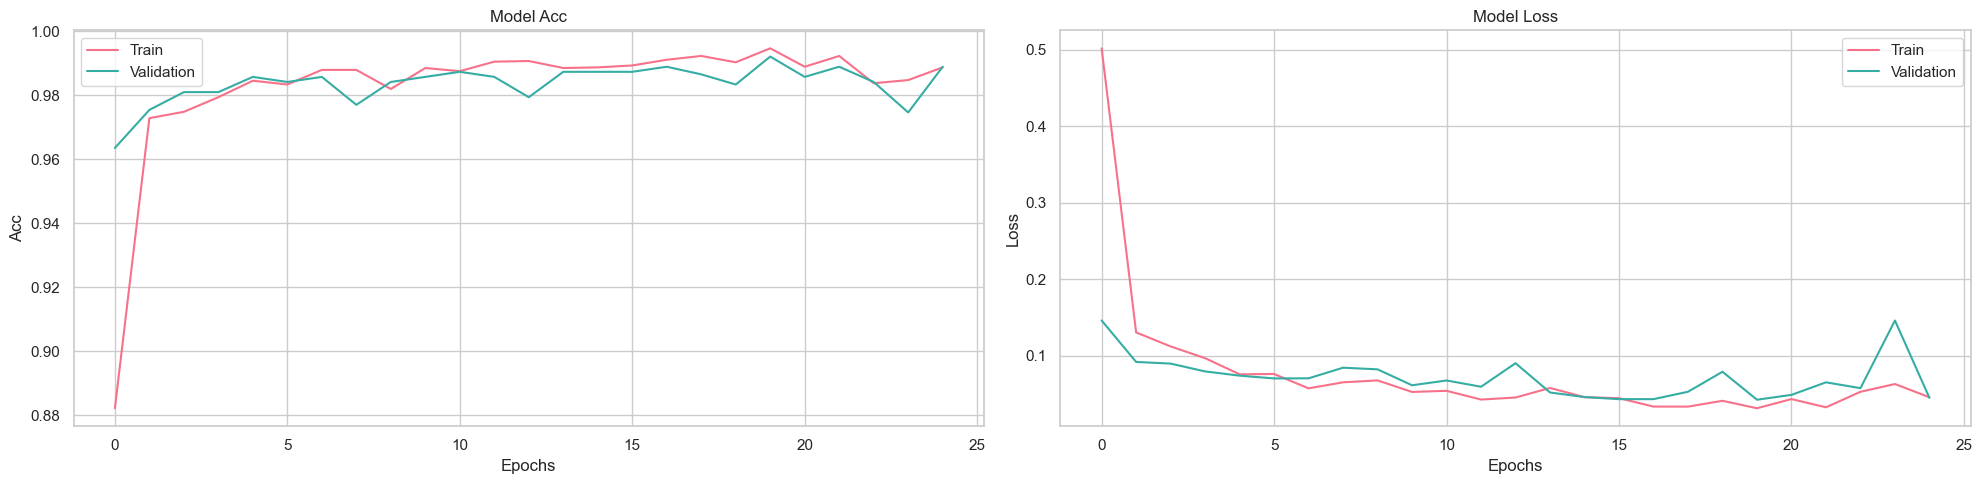

In [17]:
sns.set(style="whitegrid", rc={"axes.grid": True})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.show()

In [18]:
from PIL import Image

def predict_image(model, class_names, image_path):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))  # Resize the image
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize the image

    # Predict the class probabilities
    prediction_probs = model.predict(img_array)

    # Round off probabilities to four decimal places
    prediction_probs = np.round(prediction_probs, 4)

    # Map the prediction probabilities to class labels
    predicted_class_index = np.argmax(prediction_probs)
    predicted_class_label = class_names[predicted_class_index]

    return predicted_class_label, prediction_probs

In [19]:
image_path = '/content/drive/My Drive/THESIS/Datasets/Mary/test_data/Normal/Normal-62.png'
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/THESIS/Datasets/Mary/test_data/Normal/Normal-62.png'

In [ ]:
image_path = "/content/drive/My Drive/THESIS/Datasets/Josh's Datasets/Pneumonia-8/person7_bacteria_25.jpeg"
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

In [ ]:
image_path = "/content/drive/My Drive/THESIS/Datasets/Josh's Datasets/Pneumonia-4/person1_bacteria_1.jpeg"
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

In [ ]:
image_path = '/content/drive/My Drive/THESIS/Datasets/Mary/test_data/Tuberculosis/Tuberculosis-391.png'
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class